In [1]:
import os, re

import numpy as np
import torch
from kymatio.torch import Scattering1D

from torch.autograd import backward
import matplotlib.pyplot as plt


# 1-D Example on quasar spectrum

In [2]:
"""
read_spec.py : python version of Roman's read_spec.m
Note:
----
we can add more read_spec functions for different
datasets.
"""
from typing import Tuple

from urllib import request
import numpy as np
from astropy.io import fits


file_loader = lambda plate, mjd, fiber_id: "spec-{:d}-{:d}-{:04d}.fits".format(
    plate, mjd, fiber_id
)


def read_spec(filename: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    loads data from SDSS DR12Q coadded "speclite" FITS file;
    see
    https://data.sdss.org/datamodel/files/BOSS_SPECTRO_REDUX/RUN2D/spectra/PLATE4/spec.html
    for a complete description of the data format
    Returns:
    ----
    wavelengths     : observed wavelengths 
    flux            : coadded calibrated flux 10**-17 erg s**-1 cm**-2 A**-1
    noise_variance  : noise variance per pixel
    pixel_mask      : if 1/noise_variance = 0 and BRIGHTSKY
    TODO: can I read zQSO from spec? I guess it depends on the fits files of different surveys
    """
    with fits.open(filename) as hdu:
        # [COADD missing] some newly downloaded data do not have COADD column
        try:
            data = hdu["COADD"].data
        except KeyError as e:
            data = hdu[1].data

        # coadded calibrated flux 10**-17 erg s**-1 cm**-2 A**-1
        flux = data["flux"]

        # log_10 wavelength       log (A)
        log_wavelengths = data["loglam"]

        # inverse noise variance
        inverse_noise_variance = data["ivar"]

        # `and` mask
        and_mask = data["and_mask"]

        wavelengths = 10 ** log_wavelengths

        # handle divide by zero
        ind = inverse_noise_variance == 0
        noise_variance = np.zeros(inverse_noise_variance.shape)
        noise_variance[:] = np.nan  # fill zero division with NaNs
        noise_variance[~ind] = 1 / inverse_noise_variance[~ind]

        # derive bad pixel mask, follow the same recipe in Roman's read_spec.m
        BRIGHTSKY = 24
        pixel_mask = (inverse_noise_variance == 0) | np.array(
            [(m >> BRIGHTSKY) & 1 for m in and_mask]
        ).astype("bool")

    return wavelengths, flux, noise_variance, pixel_mask




In [3]:

def retrieve_raw_spec(plate: int, mjd: int, fiber_id: int, release: str = "dr12q"):
    """
    utility function to download a raw spec from SDSS
    """
    filename = file_loader(plate, mjd, fiber_id)

    if release == "dr12q":
        # greedy list all plates at v_5_7_2
        v_5_7_2_plates = [
            7339,
            7340,
            7386,
            7388,
            7389,
            7391,
            7396,
            7398,
            7401,
            7402,
            7404,
            7406,
            7407,
            7408,
            7409,
            7411,
            7413,
            7416,
            7419,
            7422,
            7425,
            7426,
            7428,
            7455,
            7512,
            7513,
            7515,
            7516,
            7517,
            7562,
            7563,
            7564,
            7565,
        ]

        in_5_7_2 = plate in v_5_7_2_plates
        url = "https://data.sdss.org/sas/dr12/boss/spectro/redux/{}/spectra/{:d}/spec-{:d}-{:d}-{:04d}.fits".format(
            ["v5_7_0", "v5_7_2"][in_5_7_2], plate, plate, mjd, fiber_id
        )

    elif release == "dr14q":
        url = "https://data.sdss.org/sas/dr16/eboss/spectro/redux/{}/spectra/lite/{:d}/spec-{:d}-{:d}-{:04d}.fits".format(
            "v5_13_0", plate, plate, mjd, fiber_id
        )
    else:
        raise Exception("must choose between dr12q or dr14q!")


    print("[Info] retrieving {} ...".format(url), end=" ")
    request.urlretrieve(url, filename)
    print("Done.")

Download the data (1 single spectrum)

(-1.0, 5.0)

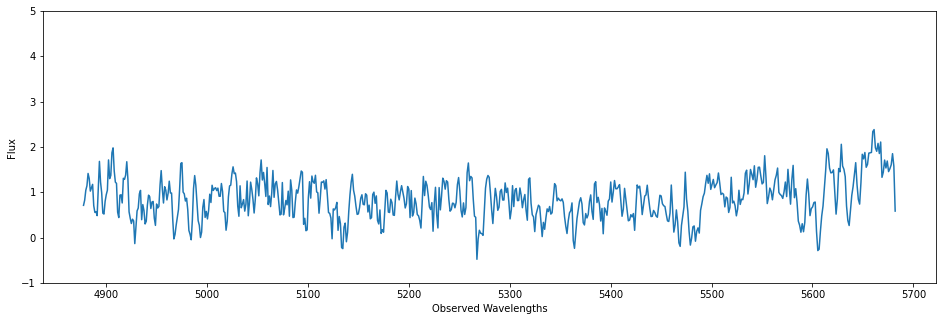

In [4]:
# read the first spectrum from SDSS DR12
nspec = 4

# a set of sample qso spectra
z_qsos = np.array(
    [
        2.30909729,
        2.49794078,
        2.328,
        2.377,
        3.71199346,
        2.163,
        2.559,
    ]
)
filenames = [
    "spec-6173-56238-0528.fits",
    "spec-6177-56268-0595.fits",
    "spec-4354-55810-0646.fits",
    "spec-6498-56565-0177.fits",
    "spec-6177-56268-0608.fits",
    "spec-4216-55477-0312.fits",
    "spec-6182-56190-0652.fits",
]
# filenames is an array for a list of spectra, and we take one of them here
filename = filenames[nspec]

# If we haven't downloaded the file, this cell will help you download the file from SDSS database
if not os.path.exists(filename):
    plate, mjd, fiber_id = re.findall(
        r"spec-([0-9]+)-([0-9]+)-([0-9]+).fits", filename,
    )[0]
    retrieve_raw_spec(int(plate), int(mjd), int(fiber_id))

# read the raw spectrum
wavelengths, flux, noise_variance, pixel_mask = read_spec(filename)

# only select the Lya region
ind = ((1025 + 10) * (1 + z_qsos[nspec]) < wavelengths) & (wavelengths < (1216 - 10) * (1 + z_qsos[nspec]))

wavelengths = wavelengths[ind]
flux = flux[ind]

# plot it in "observed wavelengths"
plt.figure(figsize=(16, 5))
plt.plot(wavelengths, flux)
plt.xlabel("Observed Wavelengths")
plt.ylabel("Flux")
plt.ylim(-1, 5)


(-1.0, 5.0)

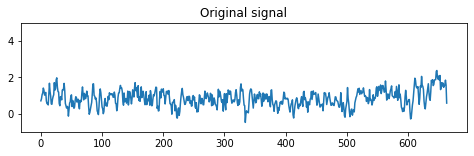

In [5]:
x = torch.from_numpy(flux.astype(np.float32))
plt.figure(figsize=(8, 2))
plt.plot(x.numpy())
plt.title("Original signal")
plt.ylim(-1, 5)


Text(0.5, 1.0, 'Spectrogram of original signal')

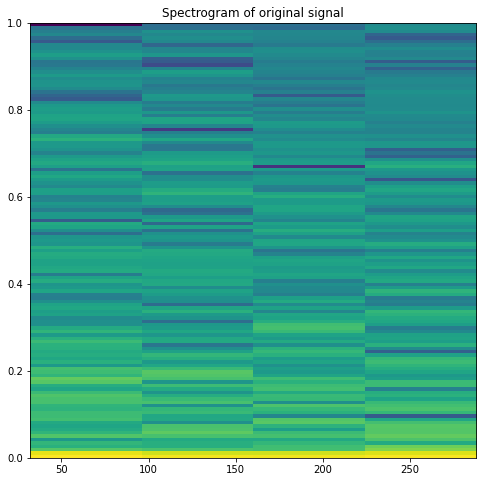

In [6]:
plt.figure(figsize=(8, 8))
plt.specgram(x.numpy())
plt.title("Spectrogram of original signal")


In [7]:
flux.size

664

In [8]:
# I tried to start with simple. The size of this Lya forest is around 2**9
# let's start with the maximum scale of filter to be 2**5
# I guess the Lya data is simpler than audio data,  let's use 8 octaves.

J = 4   # The maximum log-scale of the scattering transform. the maximum scale of the filters as a power of two. 
        # In other words, the largest filter will be concentrated in a time interval of size 2**J.
Q = 28   # The number of first-order wavelets per octave.
        # The larger the value, the narrower these filters are in the frequency domain and the wider
        # they are in the time domain (in general, the number of non-negligible oscillations in time is proportional to Q). For audio signals, 
        # it is often beneficial to have a large value for Q (between 4 and 16),

# Note: it seems like you need to have very large Q to avoid the artefact excess at the small scale power.
# Alo, 

T = x.shape[0]

scattering = Scattering1D(J, T, Q)

Sx = scattering(x)

# I didn't change the parameters set in the tutorial. Maybe I should
learning_rate = 100
bold_driver_accelerator = 1.1
bold_driver_brake = 0.55
n_iterations = 200


In [9]:
Sx.shape

torch.Size([80, 41])

In [10]:
# Random guess to initialize.
torch.manual_seed(0)
y = torch.randn((T,), requires_grad=True)
Sy = scattering(y)

history = []
signal_update = torch.zeros_like(x)

# Iterate to recontsruct random guess to be close to target.
for k in range(n_iterations):
    # Backpropagation.
    err = torch.norm(Sx - Sy)

    if k % 10 == 0:
        print('Iteration %3d, loss %.2f' % (k, err.detach().numpy()))

    # Measure the new loss.
    history.append(err)

    backward(err)

    delta_y = y.grad

    # Gradient descent
    with torch.no_grad():
        signal_update = - learning_rate * delta_y
        new_y = y + signal_update
    new_y.requires_grad = True

    # New forward propagation.
    Sy = scattering(new_y)

    if history[k] > history[k - 1]:
        learning_rate *= bold_driver_brake
    else:
        learning_rate *= bold_driver_accelerator
        y = new_y


Iteration   0, loss 5.92
Iteration  10, loss 0.45
Iteration  20, loss 0.14
Iteration  30, loss 0.10
Iteration  40, loss 0.09
Iteration  50, loss 0.09
Iteration  60, loss 0.08
Iteration  70, loss 0.08
Iteration  80, loss 0.08
Iteration  90, loss 0.08
Iteration 100, loss 0.08
Iteration 110, loss 0.08
Iteration 120, loss 0.08
Iteration 130, loss 0.08
Iteration 140, loss 0.08
Iteration 150, loss 0.08
Iteration 160, loss 0.08
Iteration 170, loss 0.08
Iteration 180, loss 0.08
Iteration 190, loss 0.08


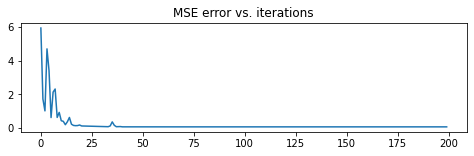

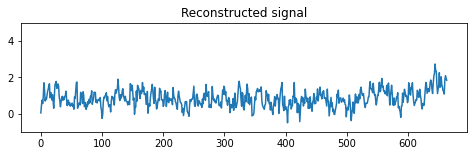

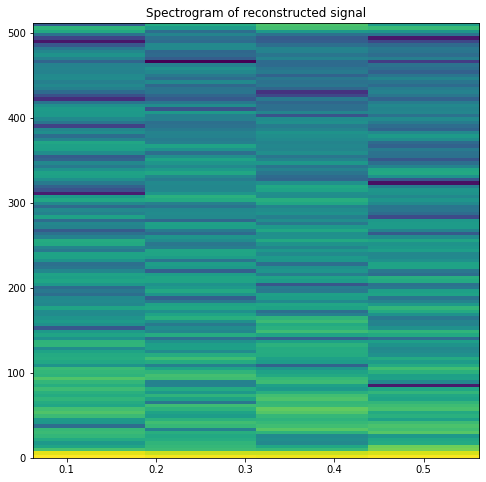

In [11]:
plt.figure(figsize=(8, 2))
plt.plot(list(map(lambda x: x.detach().numpy(), history)))
plt.title("MSE error vs. iterations")

plt.figure(figsize=(8, 2))
plt.plot(y.detach().numpy())
plt.title("Reconstructed signal")
plt.ylim(-1, 5)

plt.figure(figsize=(8, 8))
plt.specgram(y.detach().numpy(), Fs=1024)
plt.title("Spectrogram of reconstructed signal")

plt.show()

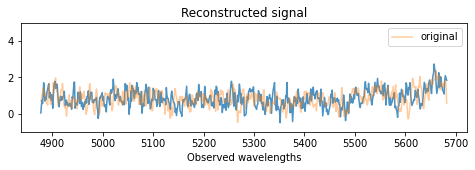

In [12]:
plt.figure(figsize=(8, 2))
plt.plot(wavelengths, y.detach().numpy(), alpha=0.8)
plt.plot(wavelengths, flux, label="original", alpha=0.4)
plt.title("Reconstructed signal")
plt.ylim(-1, 5)
plt.xlabel("Observed wavelengths")
plt.legend()


Zoom in into Lya region for investigation

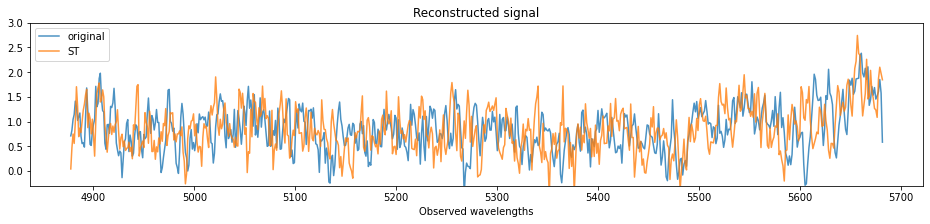

In [13]:
plt.figure(figsize=(16, 3))
plt.plot(wavelengths, flux, label="original", alpha=0.8)
plt.plot(wavelengths, y.detach().numpy(), label="ST", alpha=0.8,)
plt.title("Reconstructed signal")
plt.ylim(-0.3, 3)
plt.xlabel("Observed wavelengths")
plt.legend()


Plot power spectra density (power spectrum)

In [14]:
import scipy.signal as signal

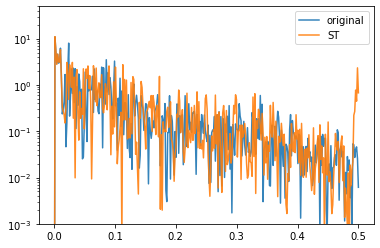

In [15]:
f, ps = signal.periodogram(flux)

f_st, ps_st = signal.periodogram(y.detach().numpy())

plt.semilogy(f, ps, label="original", alpha=0.9)
plt.semilogy(f_st, ps_st, label="ST", alpha=0.9)
plt.ylim(1e-3, 50)
plt.legend()